In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.x13 import x13_arima_analysis

%load_ext line_profiler

In [8]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
str_description_sheet = 'Description Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags.xlsx'
str_flag_sheet = 'All to check'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.h5'
str_key_description = 'descriptions_exported' ### Bloomberg tickers description list
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date coluns filled
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings (restructured to [Index_Name -> Data_Date -> Observation_Date] | Index_Value series)
str_key_bday_history = 'bday_history' ### Raw history vector with observation dates moved to nearest future business dates
str_key_num_history = 'num_history' ### Bday history vector with observation dates changed to their date numbers (for future matrix cube saving as hdf file)
str_key_from_date = 'idx_from_date' ### Series to get date numbers from dates
str_key_to_date = 'idx_to_date' ### Series to get dates from date numbers
### HDF file with matrices:
str_path_bb_matrix_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices.h5'
str_key_matrix_z = 'matrix_cube_z_scored'
### HDF file with diagonal:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_key_diag_daily = 'matrix_diagonal'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_start = datetime_start.date()
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
### Gaps filling options
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5


In [4]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, parse_dates = True,
                               na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block seperately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_idx_hdf, key = str_key_exported, mode = 'w')

In [5]:
### RUN TO RE-EXPORT DATA: DESCRIPTION FILE EXPORT

### Readind excel file:
df_description = pd.read_excel(io = str_path_bb_idx_source, sheet_name = str_description_sheet, skiprows = [0], usecols = list(range(10)), index_col = 0, header = 0, 
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_description.dropna(how = 'all', inplace = True)
df_description.index.name = 'Index_Name'
### Types converting:
df_description = df_description.astype({'ID_BB0': int,
                                        'SECURITY_DES': str,
                                        'SHORT_NAME': str,
                                        'FEED_CODE': str,
                                        'INDX_SOURCE': str,
                                        'COUNTRY': str,
                                        'INDX_HIST_START_DT_MONTHLY': str,
                                        'DES_NOTES': str,
                                        'INDX_FREQ': str,                       
                                      })
### Exported dataframe saving:
df_description.to_hdf(str_path_bb_idx_hdf, key = str_key_description, mode = 'a')

In [6]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(16)), index_col = 4, header = 0, 
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_idx_hdf, key = str_key_flags, mode = 'a')

In [9]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_exported)[
                                   ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE']]
### Dropping rows with all Index Values missed (96,369 rows left):
#df_all_idx_revisions = \
#        df_all_idx_revisions.loc[df_all_idx_revisions['PX_LAST'].notna() | df_all_idx_revisions['ACTUAL_RELEASE'].notna() | df_all_idx_revisions['FIRST_REVISION'].notna()]
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date']

In [10]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 15 : JNLSUCTL Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNLSUCTL Index', '2003-01-31'), 'Release_Date'] = pd.to_datetime('2003-03-01')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 20 : SVAWRYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-08-31'), 'Release_Date'] = pd.to_datetime('2006-10-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-09-30'), 'Release_Date'] = pd.to_datetime('2006-11-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-10-31'), 'Release_Date'] = pd.to_datetime('2006-12-17')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 26 : IEIPIMOM Index partly dropping due to the gap:
str_ei_to_correct = 'IEIPIMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 27 : ITNHMOM Index partly dropping due to the gap:
str_ei_to_correct = 'ITNHMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-03-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 32 : UKISCTMM Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('UKISCTMM Index', '1992-12-31'))
### 33 : IERSVMOM Index adding missed rows:
str_ei_to_correct = 'IERSVMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-01-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-02-28')), All] = np.NaN
### 34 : ITNHMOM Index adding missed rows:
str_ei_to_correct = 'ITNHMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-08-31')), All] = np.NaN
### 35 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'NEISIYOY Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-11-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2002-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2003-07-31')), All] = np.NaN
### 36 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [11]:
### RUN TO TESTING: RELEASE DATE < DATA DATE

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1) - pd.offsets.BDay(15)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())

Index(['ECO1GFKC Index', 'FRQBMOP3 Index', 'GRZECURR Index', 'GRZEEUEX Index',
       'GRZEWI Index', 'MTEF1C Index', 'SNTEEUGX Index'],
      dtype='object', name='Index_Name')


In [12]:
### RUN TO TESTING: REVISION DATE < RELEASE DATE

df_less_release_date = df_all_idx_revisions.loc[df_all_idx_revisions['Revision_Date'] < df_all_idx_revisions['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index([], dtype='object', name='Index_Name')
Empty DataFrame
Columns: [Final_Value, Release_Date, Release_Value, Revision_Date, Revision_Value, Future_Date]
Index: []


In [13]:
### RUN TO TESTING: RELEASE DATE >> DATA DATE

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions.index.get_level_values(1) + pd.offsets.BDay(150)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())
print(df_less_data_date.loc[('ASPPIMOM Index', All), All])

Index(['ASPPIMOM Index'], dtype='object', name='Index_Name')
                           Final_Value Release_Date  Release_Value  \
Index_Name     Data_Date                                             
ASPPIMOM Index 2003-01-31          NaN   2003-09-25            0.6   
               2003-02-28          NaN   2003-10-15            0.4   
               2003-03-31          NaN   2003-10-30            0.2   

                          Revision_Date  Revision_Value Future_Date  
Index_Name     Data_Date                                             
ASPPIMOM Index 2003-01-31           NaT             NaN  2003-10-15  
               2003-02-28           NaT             NaN  2003-10-30  
               2003-03-31           NaT             NaN  2003-11-14  


In [14]:
### RUN TO TESTING: RELEASE DATE > NEXT RELEASE DATE

df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_next'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
df_less_release_date = df_released_date.loc[df_released_date['Release_Date_next'] < df_released_date['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index(['GKCPIUHY Index', 'GKCPNEWY Index'], dtype='object', name='Index_Name')
                          Release_Date Release_Date_next
Index_Name     Data_Date                                
GKCPIUHY Index 2003-11-30   2004-01-26        2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26        2004-01-09


In [15]:
### RUN TO TESTING: EXTRA SHORT INTERVALS

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra minimum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])

Frequency control: Extra minimum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [16]:
### RUN TO TESTING: EXTRA LONG INTERVALS

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra maximum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 3 < df_eco_ind_agg['max']])

Frequency control: Extra maximum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [17]:
### RUN TO TESTING: DATA QUALITY AND COMPLETENESS

### Release Date <= Event Date:
print('Overall observations number:', len(df_all_idx_revisions.index))
df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1)]
print('Observations with Release Date < Data Date number:', len(df_less_data_date.index))
print('Unique Eco Indices with Release Date < Data Date cases number:', len(df_less_data_date.index.get_level_values(0).unique()))
### Release Date vs First Revision Date:
print('Release Date > First Revision Date:\n', 
      df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions['Revision_Date'], ['Release_Date', 'Revision_Date']])
### Release Date vs next Release Date:
df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_shifted'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
print('Release Date > next Release Date:\n', df_released_date.loc[df_released_date['Release_Date'] > df_released_date['Release_Date_shifted']])
### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra short intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])
print('Frequency control: Extra long intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 2 < df_eco_ind_agg['max']])

Overall observations number: 86501
Observations with Release Date < Data Date number: 9913
Unique Eco Indices with Release Date < Data Date cases number: 80
Release Date > First Revision Date:
 Empty DataFrame
Columns: [Release_Date, Revision_Date]
Index: []
Release Date > next Release Date:
                           Release_Date Release_Date_shifted
Index_Name     Data_Date                                   
GKCPIUHY Index 2003-11-30   2004-01-26           2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26           2004-01-09
Frequency control: Extra short intervals:
 Empty DataFrame
Columns: [min, max, median]
Index: []
Frequency control: Extra long intervals:
                 min   max  median
Index_Name                       
JCOMHCF Index  28.0  92.0    31.0


In [18]:
### RUN TO RE-EXPORT DATA: EXTRACTING Release and first revision date/value pairs:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [19]:
### RUN TO TESTING: MAIN STATS

### General stats:
print('Rows with at least one value filled:', len(df_all_idx_revisions.index))
print('Eco Indices number:', len(df_all_idx_revisions.index.get_level_values(0).unique()))
print('Average data dates number:', int(df_all_idx_revisions.groupby('Index_Name').apply(lambda df_group: len(df_group.index)).mean()))
### Release data analyzing (96,369 rows):
### Data quantity:
print('Release Info: filled date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: empty date & value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].isna()]), 'rows')
print('Release Info: empty date & filled value:', len(df_release_based.loc[df_release_based['Observation_Date'].isna() & df_release_based['Index_Value'].notna()]), 'rows')
print('Release Info: filled date & empty value:', len(df_release_based.loc[df_release_based['Observation_Date'].notna() & df_release_based['Index_Value'].isna()]), 'rows')
### First revision data analyzing (96,369 rows):
### Data quantity:
print('First revision Info: filled date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: empty date & value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].isna()]), 'rows')
print('First revision Info: empty date & filled value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].isna() & df_revision_based['Index_Value'].notna()]), 'rows')
print('First revision Info: filled date & empty value:', 
      len(df_revision_based.loc[df_revision_based['Observation_Date'].notna() & df_revision_based['Index_Value'].isna()]), 'rows') 

Rows with at least one value filled: 86501
Eco Indices number: 255
Average data dates number: 339
Release Info: filled date & value: 50929 rows
Release Info: empty date & value: 32902 rows
Release Info: empty date & filled value: 445 rows
Release Info: filled date & empty value: 2225 rows
First revision Info: filled date & value: 15292 rows
First revision Info: empty date & value: 71148 rows
First revision Info: empty date & filled value: 57 rows
First revision Info: filled date & empty value: 4 rows


In [20]:
### RUN TO TESTING: DETAILED STATS: RELEASE DATE/VALUE PAIR

print('Eco Indices without any release date number:', len(ser_empty_release_date.index))
print('Eco Indices without any release value number:', len(ser_empty_release_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty release info Eco Indices lists:', list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index))))
print('Union of empty release info Eco Indices lists:\n', sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index)))))
for iter_eco_index in sorted(list(set(ser_empty_release_date.index).symmetric_difference(set(ser_empty_release_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Release_Date', 'Release_Value'], how = 'all'))

Eco Indices without any release date number: 10
Eco Indices without any release value number: 10
Symmetric difference of empty release info Eco Indices lists: []
Union of empty release info Eco Indices lists:
 ['DTSRR1EB Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'IEVHNEWY Index', 'JNBTCASE Index', 'JNRSLYYT Index', 'LTSBBCBU Index', 'NHSPAWE1 Index', 'RSSA25M Index']


In [19]:
### RUN TO TESTING: DESCRIPTION OF PX_LAST ONLY ECO INDICES

#df_description = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_description)
#df_description.loc[list_empty_release]#.to_excel('Data_Files/Test_Files/PX_LAST_only_indices.xlsx')

In [21]:
### RUN TO TESTING: DETAILED STATS: FIRST REVISION DATE/VALUE PAIR

print('Eco Indices without any revision date number:', len(ser_empty_revision_date.index))
print('Eco Indices without any revision value number:', len(ser_empty_revision_value.index))
### Empty Eco Indices relese info lists comparision:
print('Symmetric difference of empty revision info Eco Indices lists:', 
      sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))))
print('Union of empty revision info Eco Indices lists:\n', sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index)))))
for iter_eco_index in sorted(list(set(ser_empty_revision_date.index).symmetric_difference(set(ser_empty_revision_value.index)))):
    print('Symmetric difference for', iter_eco_index, ':\n', 
          df_all_idx_revisions.loc[(iter_eco_index, All), All].dropna(subset = ['Revision_Date', 'Revision_Value'], how = 'all'))

Eco Indices without any revision date number: 73
Eco Indices without any revision value number: 73
Symmetric difference of empty revision info Eco Indices lists: []
Union of empty revision info Eco Indices lists:
 ['BAKETOT Index', 'BECCN Index', 'BECPCHNG Index', 'BRCPALLY Index', 'CONSSENT Index', 'DTSRR1EB Index', 'ESCPLMOM Index', 'ESRSREHY Index', 'EUNOEUM Index', 'FICP00MM Index', 'FIPPIR2M Index', 'FIUER Index', 'GKCPIUHY Index', 'GKCPNEWY Index', 'GKUERATE Index', 'GRCP2BRM Index', 'GRCP2BVM Index', 'GRCP2NRM Index', 'GRCP2SAM Index', 'GRZECURR Index', 'GRZEEUEX Index', 'GRZEWI Index', 'IECPEUIQ Index', 'IECPIMOM Index', 'IECSINDX Index', 'IEVHNEWY Index', 'ITSR1B Index', 'JCOMHCF Index', 'JNBTCASE Index', 'JNCAP Index', 'JNCVSSY Index', 'JNDSNYOY Index', 'JNDSTYOY Index', 'JNRSLYYT Index', 'JNSMTYOY Index', 'JNVHSYOY Index', 'JWCOOVRL Index', 'JWEXOVRL Index', 'KPRSLFLS Index', 'LTSBBCBU Index', 'MPMIDEMA Index', 'MPMIDESA Index', 'MPMIEZCA Index', 'MPMIEZMA Index', 'MPMIEZSA 

In [22]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_description = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_description)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_description.loc[str_index_name, 'INDX_FREQ']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value']]

### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [23]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 41 : SVUER Index Revision Date shifts correction: 
df_dates_filled.loc[('SVUER Index', '2005-06-30'), 'Revision_Date'] = pd.to_datetime('2005-09-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Dataframe types control:
print(df_dates_filled.dtypes)
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled, mode = 'a')

Release_Date      datetime64[ns]
Release_Value            float64
Revision_Date     datetime64[ns]
Revision_Value           float64
Final_Date        datetime64[ns]
Final_Value              float64
dtype: object


In [24]:
### RUN TO TESTING: CHECKING FOR FINAL VALUE WITHOUT FINAL DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Value'].notna() & df_dates_filled['Final_Date'].isna()]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [25]:
### RUN TO TESTING: CHECKING FOR REVISION DATE TO BE AFTER RELEASE DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [26]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER RELEASE DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [27]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER REVISION DATE:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Revision_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value
Index_Name,Data_Date,,,,,,


In [28]:
### RUN TO TESTING: CHECKING FOR RELEASE PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Release_Date'].isna() & df_dates_filled['Release_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


In [29]:
### RUN TO TESTING: CHECKING FOR REVISION PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Revision_Date'].isna() & df_dates_filled['Revision_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


In [30]:
### RUN TO TESTING: CHECKING FOR FINAL PAIR COMPLETENESS:

df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
print(df_dates_filled.loc[df_dates_filled['Final_Date'].isna() & df_dates_filled['Final_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value]
Index: []


Country                   Italy
Type                        INF
Category                   None
Name         Italy HICP MoM NSA
Units                   Percent
Frequency                     M
Name: ITCPEM Index, dtype: object


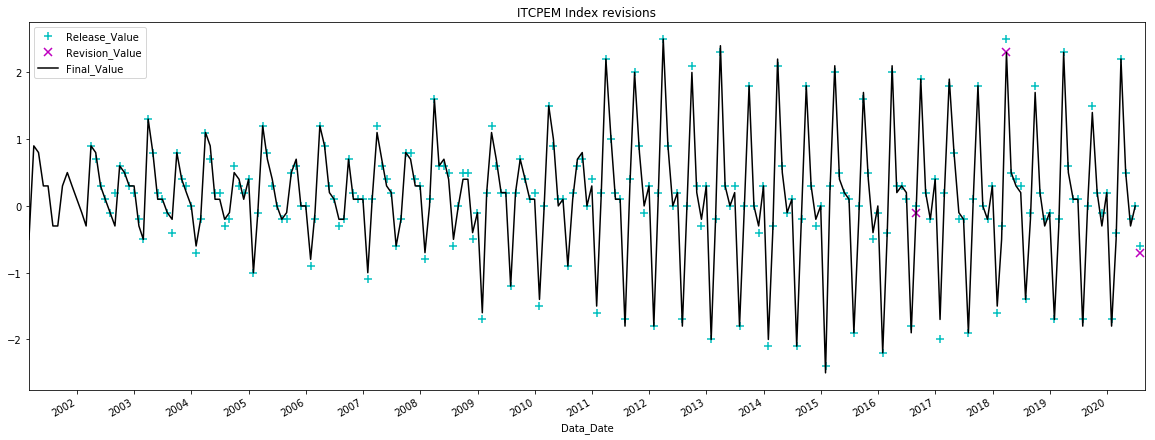

In [31]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL

### Index choosing:
str_test_index = 'ITCPEM Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)[['Release_Value', 'Revision_Value', 'Final_Value']]
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Flags printing:
print(df_flags.loc[str_test_index, ['Country', 'Type', 'Category', 'Name', 'Units', 'Frequency']])
### Series creating:
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
#date_xlim_finish = datetime(2020, 1, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind.plot(figsize = (20, 7.5), title = str_test_index + ' revisions', 
                style = ['c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))                
plt.show() 

In [32]:
### RUN TO RE-EXPORT DATA: VALUES STACKING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()
#df_release_pair['Stage'] = 'Release'
#ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna()
ser_revision_based = df_revision_pair.set_index('Observation_Date', append = True).squeeze()
#df_revision_pair['Stage'] = 'First Revision'
#ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna()
ser_final_based = df_final_pair.set_index('Observation_Date', append = True).squeeze()
#df_final_pair['Stage'] = 'Final Revision'
#ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_history, mode = 'a')

In [33]:
### RUN TO RE-EXPORT DATA: HISTORY REINDEXATION TO OBSERVATION DATE BUSINESS DAILY MATRIX STRUCTURE (PRELIMINARY ACTIONS)

### Data loading:
ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
ser_history_bday = ser_history_bday.loc[All, All, idx_date_range]
### Data adding to hdf collection:
ser_history_bday.to_hdf(str_path_bb_idx_hdf, key = str_key_bday_history, mode = 'a') ### BDay moved observation dates

In [ ]:
### UNDER CONSTRUCTION: SEASONALITY ADJUSTMENT RESEARCH

ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)

In [ ]:
### UNDER CONSTRUCTION: SEASONALITY ADJUSTMENT RESEARCH

str_date_test = '2020-08-31' # '2014-12-31' # 
str_ticker_test = 'UKRPMOM Index' # 'ITCPEM Index'
ser_test_full = ser_history_bday.loc[str_ticker_test, All].droplevel('Index_Name')
ser_test_full = ser_test_full.unstack('Data_Date').reindex(idx_date_range).stack('Data_Date', dropna = False).squeeze()
ser_test_full = ser_test_full.swaplevel()
ser_test_full.index.rename('Observation_Date', level = -1, inplace = True)    
ser_test_full = ser_test_full.groupby('Data_Date').ffill().sort_index()

ser_test_obs = ser_test_full.loc[: str_date_test, str_date_test].droplevel('Observation_Date')

int_correction = 100

#ser_test_obs

In [ ]:
### UNDER CONSTRUCTION: SEASONALITY ADJUSTMENT RESEARCH

def sa_time_test(ser_test_obs, algo = 'x13', int_correction = 100):
    date_obs_date = ser_test_obs.index.get_level_values('Observation_Date')[0]
    ser_test_obs = ser_test_obs.droplevel('Observation_Date').loc[: date_obs_date].dropna()
    if ((len(ser_test_obs.index) > 40) & (date_obs_date == date_obs_date + pd.tseries.offsets.BMonthEnd(0))):
        ser_test_obs.name = 'Test'
        if (algo == 'x13'):
            ser_test_sa = x13_arima_analysis(ser_test_obs + int_correction, outlier = False).seasadj
        else:
            ser_test_sa = seasonality_adjustment(ser_test_obs + int_correction)
        return ser_test_sa
#sa_time_test(ser_test_full.loc[: str_date_test, str_date_test], algo = 'x13')
ser_test_res = ser_test_full.groupby('Observation_Date').apply(sa_time_test, algo = 'x13')

In [ ]:
### UNDER CONSTRUCTION: SEASONALITY ADJUSTMENT RESEARCH

#%env
#%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as

In [ ]:
### UNDER CONSTRUCTION: SEASONALITY ADJUSTMENT RESEARCH

### X13 ARIMA SEATS (CENSUS)
ser_test_sa = x13_arima_analysis(ser_test_obs.dropna() + int_correction, prefer_x13 = False, outlier = True).seasadj
pd.concat([ser_test_obs + int_correction, ser_test_sa], axis = 1).to_excel('Data_Files/Test_Files/Seasonality_adjustment_test.xlsx', merge_cells = False)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (REINDEXATION, FLAGS IMPLEMENTATION, Z-SCORING)

### Defining Economic Index sseries transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length):
    ### Local constants definition:
    dict_interval = {}
    dict_interval['Q'] = 4
    dict_interval['M'] = 12
    dict_interval['W'] = 52      
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ser_result = ser_date.droplevel('Data_Date')
        ser_result = ser_result[ser_result.index >= date_diag] 
        return ser_result
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit):
        if (ser_date.std() > flo_winsorize_tolerance):
            ### Calculating of z scores:
            ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
            bool_to_winsor = True   
            int_iter = 1
            while (bool_to_winsor): 
                int_iter += 1                
                ### Value based winsorization:                
                ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                ### Recalculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                ### Checking for boundaries and steps:
                if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_winsorize_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                    bool_to_winsor = False
        else:
            ### Constant values demeaning:
            ser_date = ser_date - ser_date.mean()
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range)
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type'] == 'TAR'):
        print(ser_name.index.get_level_values(0)[0], ': TAR Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Eco Index demeaning:
        if ser_flags['Demean']:
            print(ser_name.index.get_level_values(0)[0], ': Demean flag implementing')
            ser_triangle = ser_triangle - 50
        ### Eco Index rebasing for Index-based Eco Indices:
        if ser_flags['Index']:
            print(ser_name.index.get_level_values(0)[0], ': Index flag implementing')            
            ### For relative index:            
            if ser_flags['YoY']:
                int_interval = dict_interval[ser_flags['Frequency']]
                for int_shift in range(int_interval):
                    idx_interval = ser_triangle.index.levels[0][int_shift :: int_interval]
                    date_interval_start = ser_triangle.index.levels[0][int_shift]
                    ser_triangle.loc[idx_interval, All] = ser_triangle.loc[idx_interval, All] / 100.0 + 1
                    ser_triangle.loc[date_interval_start, All] = ser_triangle.loc[date_interval_start, All] * 100.0
                    idx_isna = ser_triangle.loc[idx_interval, All].loc[ser_triangle.loc[idx_interval, All].isna() == True].index
                    ser_triangle.loc[idx_isna] = 1
                    ser_triangle.loc[idx_interval, All] = ser_triangle.loc[idx_interval, All].groupby('Observation_Date').cumprod()
                    ser_triangle.loc[idx_isna] = np.NaN                    
            ### For through index:    
            else:
                ser_triangle = ser_triangle / 100.0 + 1
                ser_triangle.loc[ser_triangle.index.levels[0][0], All] = ser_triangle.loc[ser_triangle.index.levels[0][0], All] * 100.0
                idx_isna = ser_triangle.isna()
                ser_triangle.loc[idx_isna] = 1
                ser_triangle = ser_triangle.groupby('Observation_Date').cumprod()
                ser_triangle.loc[idx_isna] = np.NaN
        ### Eco Index rebasing for Sum-based Eco Indices:
        if ser_flags['Sum']:
            print(ser_name.index.get_level_values(0)[0], ': Sum flag implementing')             
            ### For relative index:            
            if ser_flags['YoY']:
                int_interval = dict_interval[ser_flags['Frequency']]
                for int_shift in range(int_interval):
                    idx_interval = ser_triangle.index.levels[0][int_shift :: int_interval]
                    idx_isna = ser_triangle.loc[idx_interval, All].loc[ser_triangle.loc[idx_interval, All].isna() == True].index
                    ser_triangle.loc[idx_isna] = 0
                    ser_triangle.loc[idx_interval, All] = ser_triangle.loc[idx_interval, All].groupby('Observation_Date').cumsum()
                    ser_triangle.loc[idx_isna] = np.NaN                   
            ### For through index:    
            else:
                idx_isna = ser_triangle.isna()
                ser_triangle.loc[idx_isna] = 0
                ser_triangle = ser_triangle.groupby('Observation_Date').cumsum()
                ser_triangle.loc[idx_isna] = np.NaN
        ### Eco Index rebasing for Adjustment-based Eco Indices:
        if ser_flags['Adjustment']:    
            print(ser_name.index.get_level_values(0)[0], ': Adjustment flag implementing')    
            int_adjustment = ser_flags['Adjustment'] // 3
            ser_triangle = ser_triangle.groupby('Observation_Date').diff(int_adjustment)       
        ### Eco Index rebasing for log-based Eco Indices:
        if ser_flags['Log']:        
            print(ser_name.index.get_level_values(0)[0], ': Log flag implementing')
            ### For relative index:            
            if ser_flags['YoY']:            
                pass
            ### For through index:    
            else:
                if (len(ser_triangle[ser_triangle <= 0].index) > 0):
                    ser_triangle = ser_triangle + 2 * abs(ser_triangle.min())
                ser_triangle = np.log(ser_triangle)
        ### Eco Index rebasing for Negative-based Eco Indices:
        if ser_flags['Negative']:       
            print(ser_name.index.get_level_values(0)[0], ': Negative flag implementing')            
            ser_triangle = -ser_triangle    
    ### Z-scoring across the observation dates:
    print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
    ser_triangle_z = ser_triangle.groupby('Observation_Date').apply(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit)
    ### Adding results to matrix cube:
    pd.concat([ser_triangle_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                        complevel = 9, append = True, mode = 'a',
                                                                                        min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return ser_triangle

### Flags loading:
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_bday.index.levels[0].str.len())
### Data transforming:
print(datetime.now())
ser_history_bday.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags, int_max_name_length)
print(datetime.now())
#str_test_key = 'ADP CHNG Index'
#ser_ei_test = ser_history_bday.loc[[str_test_key], All, All].groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags, int_max_name_length)

In [35]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [ ]:
### RUN TO RE-EXPORT DATA:DIAGONAL CONSTRUCTING:

### Creating container for tikers diagonals:
dict_ei_diag = {}
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Tickers list preparing:
idx_ticker_list = ser_history_bday.index.levels[0]
### Looping over tickers:
for iter_ticker in idx_ticker_list:
    print(iter_ticker)
    ### Extracting unique observation dates for each ticker:
    idx_date_list = ser_history_bday.loc[iter_ticker, All, All].index.get_level_values(-1).unique()
    ### Creating future diagonal vector:
    ser_iter_diag = pd.Series(np.NaN, idx_date_list)
    ### Loading matrix for each ticker:
    ser_iter_matrix = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == iter_ticker').droplevel('Index_Name')
    ### Looping over unique dates:
    for iter_date in idx_date_list:
        ### Trying to get the latest data date observation:
        try:
            ser_iter_diag[iter_date] = ser_iter_matrix.loc[All, iter_date].dropna()[-1]
        except:
            pass
    ### Saving ticker diagonal to the container:
    dict_ei_diag[iter_ticker] = ser_iter_diag
### Aggragating ticker diagonals:
ser_diagonal = pd.concat(dict_ei_diag, axis = 0)
ser_diagonal.index.set_names(['Index_Name'], level = [0], inplace = True)
ser_diagonal.name = 'EI_diagonal'
### Reindexin diagonals to daily vector and filling the gaps:
ser_diagonal = ser_diagonal.groupby('Index_Name').apply(lambda ser_ticker: ser_ticker.droplevel('Index_Name').reindex(idx_date_range).ffill())
ser_diagonal.index.set_names(['Date'], level = [-1], inplace = True)
### Saving results to hdf file:
ser_diagonal.to_hdf(str_path_bb_diag_hdf, key = str_key_diag_daily, mode = 'w')

In [50]:
### TEMP

str_test_key = 'USURTOT Index'
ser_test = ser_diagonal.loc['USURTOT Index', date_test]#.drop_duplicates()
ser_test

0.7071067690849304

In [49]:
### TEMP

date_test = '1985-05-06'
ser_matrix = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_test_key')
ser_matrix.droplevel(0).loc[All, All].dropna()

Data_Date   Observation_Date
1985-01-31  1985-04-08         -0.000000
            1985-05-06         -0.707107
            1985-06-06         -0.577350
            1985-07-08         -0.000000
            1985-08-06         -0.239046
                                  ...   
2020-05-31  2020-07-02          5.016171
            2020-08-07          5.012336
2020-06-30  2020-07-02          5.016171
            2020-08-07          5.012336
2020-07-31  2020-08-07          4.935615
Length: 91091, dtype: float32